In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [33]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)

In [34]:
def greens_function(config, old_config, alpha, beta, kappa, gamma, delta_t):
    norm_diff = np.linalg.norm(config - old_config)
    return (1/np.sqrt(4*np.pi* gamma*delta_t)) * np.exp(-norm_diff**2 / (4*gamma*delta_t))

In [43]:
def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*(r_1+r_2))*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*(vec_r_1-vec_r_2))
    force_2 = 2*(-kappa*(vec_r_2/r_2)+factor*(vec_r_2-vec_r_1))
    return np.array([force_1, force_2])

def metropolis_algorithm(initial_state, num_trials, s, alpha, beta, kappa, use_FP = False, disable_tqdm = False):
    sequence_states = [initial_state]
    for _ in tqdm(range(num_trials), disable=disable_tqdm):
        next_sequence = metropolis_step(sequence_states[-1], alpha, beta, s, kappa, use_FP=use_FP)
        sequence_states.append(next_sequence)
    return np.array(sequence_states)
   
def metropolis_step(current_state, alpha, beta, s, kappa, use_FP=False):
    trial_configuration = current_state.copy()
    new_state = np.zeros(current_state.shape)
    for i in range(M):
        which_particle = np.random.choice([0,M]) # Todo: Is this chosen for each of the M seperately?
        #if use_FP:
         #   trial_configuration[i+which_particle] += Fokker_planck(current_state[i], current_state[i+M], alpha, kappa, beta)*delta_t/2
        trial_configuration[i+which_particle] += np.random.uniform(low=-s/2, high=s/2, size=3)#*np.sqrt(delta_t)
        if not use_FP:
            p = (psi_T(trial_configuration[i], trial_configuration[i+M], alpha, kappa, beta)/psi_T(current_state[i], current_state[i+M], alpha, kappa, beta))**2
            trial_acceptance_prob = np.min([1, p])
        r_accept = np.random.rand()
        if r_accept < trial_acceptance_prob:
            new_state[i] = trial_configuration[i]
            new_state[i+M] = trial_configuration[i+M]
        else:
            new_state[i] = current_state[i]
            new_state[i+M] = current_state[i+M]
    return np.array(new_state)

In [7]:

alpha = 0.15
beta = 0.5
kappa = 2
print(R[0])
R_trial = R[0] + np.random.uniform(low=-1/2, high=1/2, size=3)
R_trial_2 = R[M] + np.random.uniform(low=-1/2, high=1/2, size=3)
print(R_trial)
print((psi_T(R_trial, R_trial_2, alpha, kappa, beta)/psi_T(R[0], R[M], alpha, kappa, beta))**2)

[ 0.25799704  0.13485986 -0.35736079]
[ 0.57520158  0.48210099 -0.76131643]
0.01739253000037779


In [8]:
s=1
current_state = R
trial_configuration = current_state.copy()

for i in range(M):
    trial_configuration[i] += np.random.uniform(low=-s/2, high=s/2, size=3)#*np.sqrt(delta_t)

current_r_1 = current_state[:M]
current_r_2 = current_state[M:]
trial_r_1 = trial_configuration[:M]
trial_r_2 = trial_configuration[M:]
print((psi_T(trial_r_1, trial_r_2, alpha, kappa, beta)/psi_T(current_r_1, current_r_2, alpha, kappa, beta))**2)
print(trial_r_2.shape)

1.6758867724233718e-07
(300, 3)


In [12]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), -vec_r12/r_12)
    E_L = (kappa-2)/r_1 + (kappa-2)/r_2 + (1-2*beta/u**2) +2*beta*alpha/u**3 - kappa**2 - (beta**2)/u**4 +(kappa*beta/u**2)*scalar_product    
    return E_L

def energy_statistics(simulation, accumulate_last_n, alpha, beta, kappa, disable_tqdm = False):
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    e_avg_accumulated = [np.mean(e_0)]
    e_var_accumulated = [np.std(e_0)]
    for time in tqdm(range(1, num_simulation_steps), disable=disable_tqdm): #Todo: Enable turning tqdm off
        e_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            e_t.append(e_i)
        energies.append(e_t)
    for time in range(1, num_simulation_steps, accumulate_last_n):
        if time > accumulate_last_n:
            e_avg_t = np.mean(energies[time-accumulate_last_n:time])
            e_var_t = np.std(energies[time-accumulate_last_n:time])
        else: #For the first 999 time steps:
            e_avg_t = np.mean(energies[:time])
            e_var_t = np.std(energies[:time])              
        e_avg_accumulated.append(e_avg_t)
        e_var_accumulated.append(e_var_t)
    return np.array(e_avg_accumulated), np.array(e_var_accumulated)

In [10]:
sim = metropolis_algorithm(R, num_trials=5000, s=10, alpha=0.15, beta=0.5, kappa=2)
E_avg_s, E_std_s = energy_statistics(sim, 1000, alpha=0.15, beta=0.5, kappa=2)

100%|██████████| 5/5 [00:00<00:00, 63.99it/s]


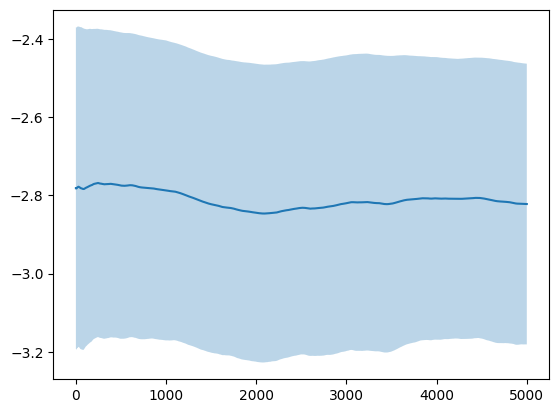

In [96]:
plt.plot(np.arange(sim.shape[0]), E_avg_s)
plt.fill_between(np.arange(sim.shape[0]), E_avg_s-E_std_s, E_avg_s+E_std_s, alpha=0.3)

In [37]:
timestep = 0
walker = 0
sim_step_r1 = sim[timestep, walker, :]
sim_step_r2 = sim[timestep, walker+M, :]
e = energy_local(sim_step_r1, sim_step_r2, alpha=0.15, beta=0.5, kappa=2)

print(sim_step_r1)
print(sim_step_r2)
print(e)

[ 0.47111873  0.07798355 -0.45012105]
[ 0.10389725 -0.46783266  0.10703362]
-2.6745152843362465


In [97]:
N = 10000 # Todo: Change back to 30k
n = 1000
list_s = [0.1,1,10]

E_avg = []
E_std = []

for s_test in list_s:
    print(f"s = {s_test}:")
    simulation_s = metropolis_algorithm(R, N, s_test, alpha=0.15, beta=0.5, kappa=2)
    E_avg_s, E_std_s = energy_statistics(simulation_s, n, alpha=0.15, beta=0.5, kappa=2)
    E_avg.append(E_avg_s)
    E_std.append(E_std_s)

s = 0.1:


100%|██████████| 10000/10000 [03:09<00:00, 52.91it/s]


s = 1:


100%|██████████| 10000/10000 [03:10<00:00, 52.61it/s]


s = 10:


100%|██████████| 10000/10000 [03:08<00:00, 53.12it/s]


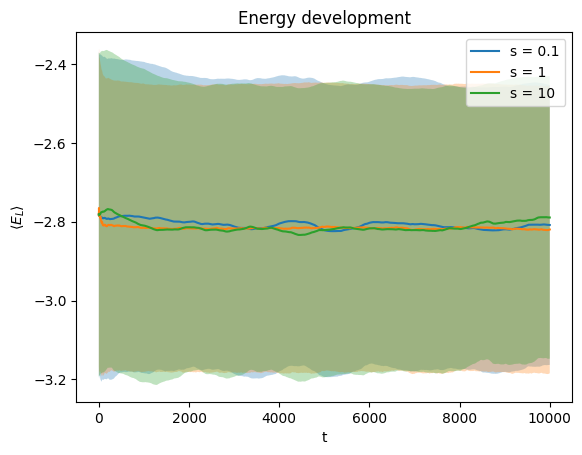

In [98]:
t = np.arange(N+1)
for i in range(len(E_avg)):
    plt.fill_between(t, E_avg[i]-E_std[i], E_avg[i]+E_std[i], alpha=0.3)
    plt.plot(t, E_avg[i], label=f"s = {list_s[i]}")
    
plt.title("Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

#Todo: Look at the time, there is something wrong, maybe therefore weird standard deviation?

In [119]:
E_avg = np.array(E_avg)
E_std = np.array(E_std)
print(pd.DataFrame({"s": list_s, "mean": E_avg[:,-1], "$\sigma$": E_std[:,-1]}))

      s      mean  $\sigma$
0   0.1 -2.808174  0.355044
1   1.0 -2.819642  0.365399
2  10.0 -2.789180  0.358577


# Problem b

In [8]:
N_b = 1000
list_alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

E_avg_alpha = []
E_std_alpha = []

for alpha in list_alpha:
    print(rf"$\alpha$ = {alpha}:")
    simulation_a = metropolis_algorithm(R, N_b, s=1, alpha=alpha, beta=0.5, kappa=2)
    E_avg_a, E_std_a = energy_statistics(simulation_a, n, alpha=alpha, beta=0.5, kappa=2)
    E_avg_alpha.append(E_avg_a)
    E_std_alpha.append(E_std_a)

$\alpha$ = 0.0:


100%|██████████| 1000/1000 [00:09<00:00, 102.43it/s]


$\alpha$ = 0.1:


100%|██████████| 1000/1000 [00:09<00:00, 103.09it/s]


$\alpha$ = 0.2:


100%|██████████| 1000/1000 [00:09<00:00, 102.05it/s]


$\alpha$ = 0.3:


100%|██████████| 1000/1000 [00:09<00:00, 103.28it/s]


$\alpha$ = 0.4:


100%|██████████| 1000/1000 [00:09<00:00, 103.03it/s]


$\alpha$ = 0.5:


100%|██████████| 1000/1000 [00:09<00:00, 103.30it/s]


In [9]:
E_avg_alpha = np.array(E_std_alpha)
E_std_alpha = np.array(E_std_alpha)

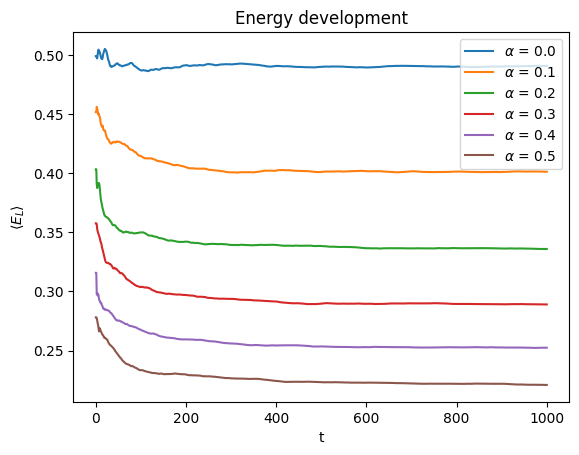

In [10]:
t_b = np.arange(1000+1)
for i in range(len(E_avg_alpha)):
    #plt.fill_between(t, E_avg_alpha[i]-E_std_alpha[i], E_avg_alpha[i]+E_std_alpha[i], alpha=0.3)
    plt.plot(t_b, E_avg_alpha[i], label= rf"$\alpha$ = {list_alpha[i]}")
    
plt.title("Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

# Problem c

In [66]:
def energy_statistics_c(simulation, equilibration_time, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=False): # Todo: If change in energy_statistics function is made, it may be necessary to change it here as well
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    for time in tqdm(range(equilibration_time, num_simulation_steps), disable=disable_tqdm):
        energies_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            energies_t.append(e_i)
        energies.append(energies_t)
    e_avg_t = np.mean(energies)
    e_var_t = np.std(energies)
    return np.array(e_avg_t), np.array(e_var_t)

In [68]:
N_c = 10000

In [54]:
M=10 #Todo: Change back to 300
n_equilibrium = 5000 # Todo: Choose appropriate value


list_alpha_c = np.linspace(0,0.5,50)

E_avg_alpha_c = []
E_std_alpha_c = []

for alpha in tqdm(list_alpha_c):
    simulation_a = metropolis_algorithm(R, N_c, s=1, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_a, E_std_a = energy_statistics_c(simulation_a, n_equilibrium, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_alpha_c.append(E_avg_a)
    E_std_alpha_c.append(E_std_a)
    
E_avg_alpha_c = np.array(E_avg_alpha_c)

100%|██████████| 50/50 [03:58<00:00,  4.78s/it]


Text(0.5, 1.0, 'Part c): Mean energy for different $\\alpha$')

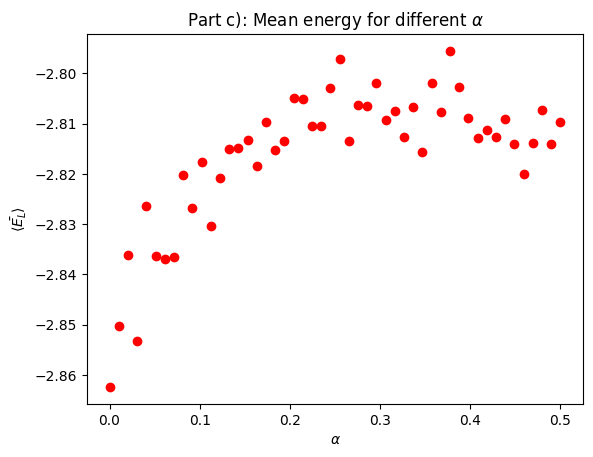

In [58]:
for i, alpha in enumerate(list_alpha_c):
    plt.plot(list_alpha_c[i], E_avg_alpha_c[i, -1], "ro", label = rf"$\alpha$ = {alpha}")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part c): Mean energy for different $\alpha$")

In [ ]:
#Todo: Plot sigma over alpha

# Problem d

In [69]:
alpha_optimal = 0.15 # Todo: Select optimal alpha from problem part c

list_kappa = np.linspace(1.7,2.2,50)

E_avg_kappa = []
E_std_kappa = []

for k in tqdm(list_kappa):
    simulation_k = metropolis_algorithm(R, N_c, s=1, alpha=alpha_optimal, beta=0.5, kappa=k, disable_tqdm=True)
    E_avg_k, E_std_k = energy_statistics_c(simulation_k, n_equilibrium, disable_tqdm=True)
    E_avg_kappa.append(E_avg_k)
    E_std_kappa.append(E_std_k)

E_avg_kappa = np.array(E_avg_kappa)

100%|██████████| 50/50 [03:27<00:00,  4.16s/it]


Text(0.5, 1.0, 'Part d): Mean energy for different $\\kappa$')

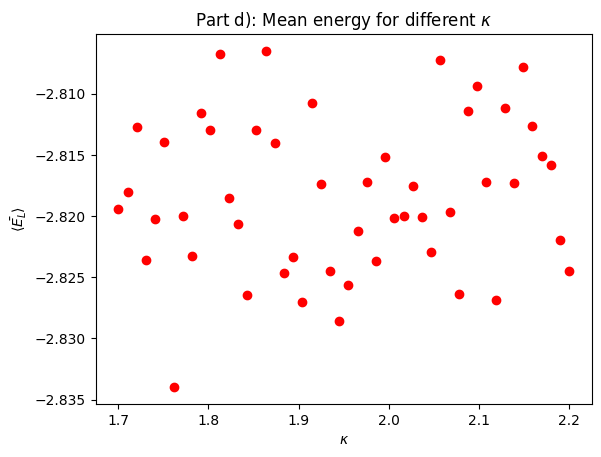

In [72]:
for i, k in enumerate(list_kappa):
    plt.plot(list_kappa[i], E_avg_kappa[i], "ro", label = rf"$\alpha$ = {k}")
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part d): Mean energy for different $\kappa$")

# Problem e

In [ ]:
beta_e = 0.38
alpha_e = 0.18 
kappa_e = 1.85
simulation_e = metropolis_algorithm(R, N_c, s=1, alpha=alpha_e, beta=beta_e, kappa=kappa_e)
E_avg_e, E_std_e = energy_statistics_c(simulation_e, n_equilibrium, disable_tqdm=True)

In [ ]:
print(E_avg_e, E_std_e)

In [ ]:
E_exp = -2.90338583

# Problem g

In [ ]:
metropolis_algorithm(initial_state, N, s=1, alpha_e, beta_e, kappa_e, use_FP = False)